# Assignment 4: K-Means and Hierarchical Clustering

**Group K:**
- Fares Gharbi (06052076)
- Shehab Hassani (06071687)
- Riddhima Tanwar (06015675)
- Leni Le Ravallec (06058195)


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## Section 1: Data Loading and Z-Score Normalization

Load the `customers.csv` dataset and apply Z-score normalization on the numerical features: **Age**, **Income**, and **Score**.

In [20]:
# Load the dataset
df = pd.read_csv('customers.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head(10)

Dataset shape: (200, 5)
Columns: ['ID', 'Gender', 'Age', 'Income', 'Score']


,ID,Gender,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [21]:
# Z-score normalisation on numerical features: Age, Income, Score
numerical_features = ['Age', 'Income', 'Score']
scaler = StandardScaler()
df_normalised = df.copy()
df_normalised[numerical_features] = scaler.fit_transform(df[numerical_features])

print("Original data (first 5 rows):")
print(df[numerical_features].head())
print("\nNormalised data (first 5 rows):")
print(df_normalised[numerical_features].head())
print(f"\nNormalised means (should be ~0): {df_normalised[numerical_features].mean().values}")
print(f"Normalised stds  (should be ~1): {df_normalised[numerical_features].std().values}")

Original data (first 5 rows):
   Age  Income  Score
0   19      15     39
1   21      15     81
2   20      16      6
3   23      16     77
4   31      17     40

Normalised data (first 5 rows):
        Age    Income     Score
0 -1.424569 -1.738999 -0.434801
1 -1.281035 -1.738999  1.195704
2 -1.352802 -1.700830 -1.715913
3 -1.137502 -1.700830  1.040418
4 -0.563369 -1.662660 -0.395980

Normalised means (should be ~0): [-1.02140518e-16 -2.13162821e-16 -1.46549439e-16]
Normalised stds  (should be ~1): [1.00250941 1.00250941 1.00250941]


## Section 2: K-Means with k = 2..10 and Best k Selection

Run K-means for k = 2, 3, ..., 10 using the normalised features. Use the **Elbow Method** (inertia / WCSS) and **Silhouette Score** to determine the best k.

In [22]:
X_normalised = df_normalised[numerical_features].values

# Run K-means for k = 2..10
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_normalised)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_normalised, labels))

# Display results
results_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia (WCSS)': inertias,
    'Silhouette Score': silhouette_scores
})
print(results_df.to_string(index=False))

 k  Inertia (WCSS)  Silhouette Score
 2      389.386189          0.335472
 3      295.212246          0.357793
 4      205.225147          0.403958
 5      168.247580          0.416643
 6      133.868421          0.428417
 7      117.011555          0.417232
 8      103.873292          0.408207
 9       93.092891          0.417693
10       82.385154          0.406554


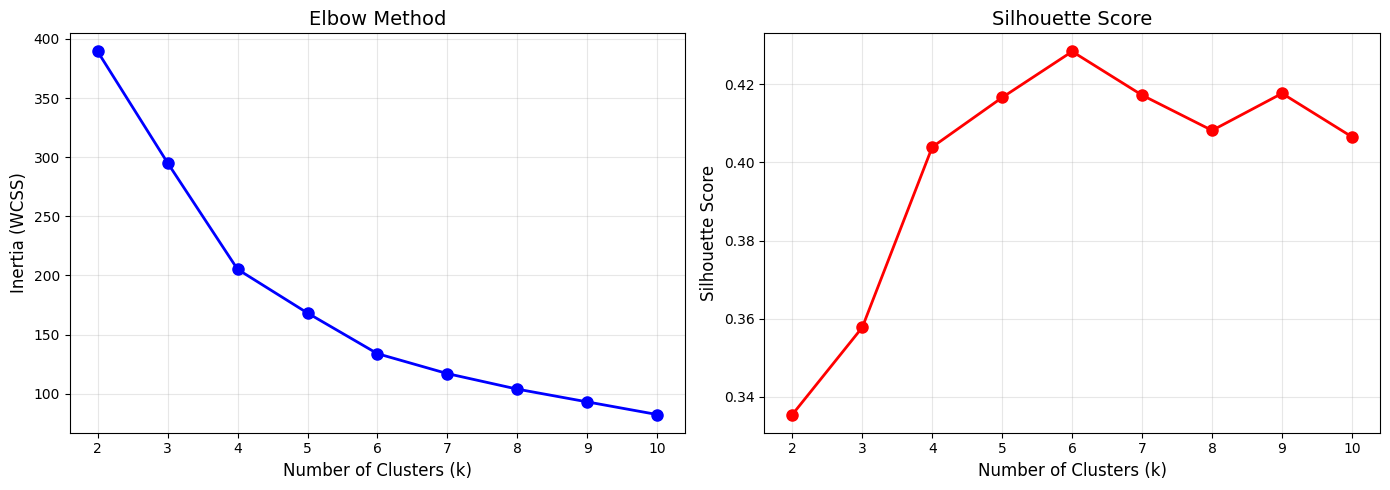


Best k (highest silhouette score): 6
Silhouette score at k=6: 0.4284

The elbow method shows a noticeable bend, while the silhouette score is maximised at k=6. We select k=6 as the optimal number of clusters.


In [23]:
# Plot Elbow Method and Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method
axes[0].plot(list(k_range), inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].set_xticks(list(k_range))
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(list(k_range), silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14)
axes[1].set_xticks(list(k_range))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine the best k using the silhouette score
best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f"\nBest k (highest silhouette score): {best_k}")
print(f"Silhouette score at k={best_k}: {max(silhouette_scores):.4f}")
print(
    f"\nThe elbow method shows a noticeable bend, "
    f"while the silhouette score is maximised at k={best_k}. "
    f"We select k={best_k} as the optimal number of clusters."
)

## Section 3: 3D Cluster Visualisation with Best k

Cluster the samples using K-means with the best k. Plot the clusters and centroids in 3D using the **denormalised** (original) axes.

In [24]:
# Fit K-means with the best k
kmeans_best = KMeans(n_clusters=best_k, n_init=10, random_state=42)
cluster_labels = kmeans_best.fit_predict(X_normalised)

# Denormalise the centroids back to original scale
centroids_normalised = kmeans_best.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_normalised)

# Add cluster labels to the dataframe
df['Cluster'] = cluster_labels

# Print centroid information
centroid_df = pd.DataFrame(
    centroids_original,
    columns=numerical_features,
    index=[f'Cluster {i}' for i in range(best_k)]
)
print(f"K-Means with k={best_k} — Cluster Centroids (original scale):\n")
print(centroid_df.round(2))
print(f"\nCluster sizes:")
print(df['Cluster'].value_counts().sort_index())

K-Means with k=6 — Cluster Centroids (original scale):

             Age  Income  Score
Cluster 0  56.33   54.27  49.07
Cluster 1  26.79   57.10  48.13
Cluster 2  41.94   88.94  16.97
Cluster 3  32.69   86.54  82.13
Cluster 4  25.00   25.26  77.61
Cluster 5  45.52   26.29  19.38

Cluster sizes:
Cluster
0    45
1    39
2    33
3    39
4    23
5    21
Name: count, dtype: int64


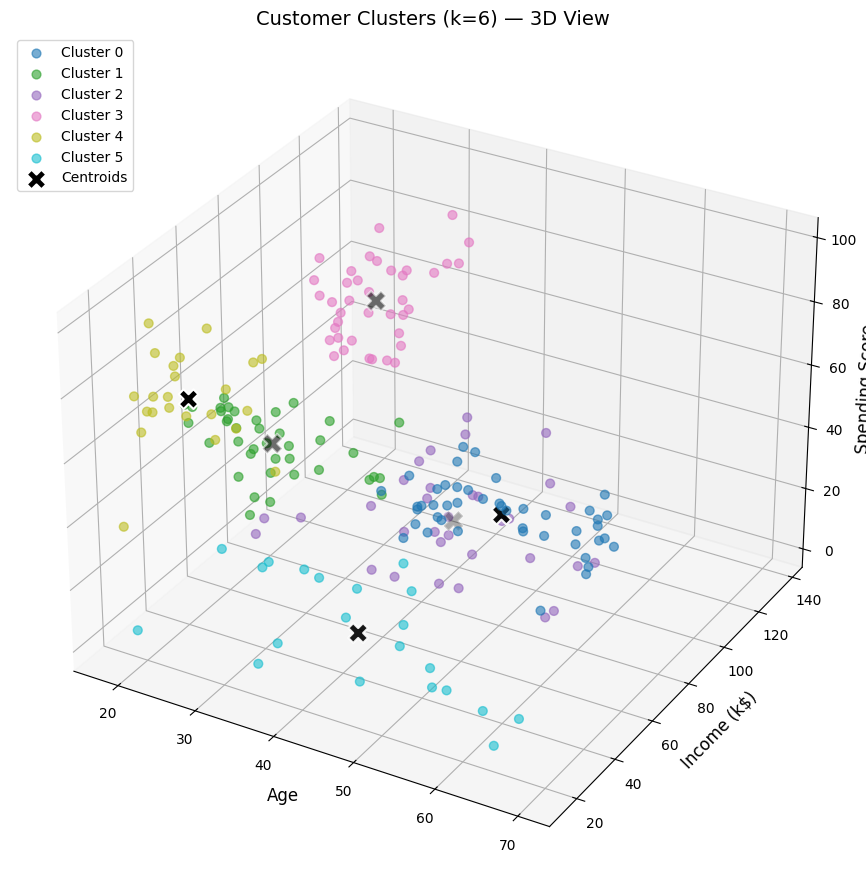

In [25]:
# 3D scatter plot with denormalised axes
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap for distinct cluster colours
colours = plt.cm.tab10(np.linspace(0, 1, best_k))

for i in range(best_k):
    mask = cluster_labels == i
    ax.scatter(
        df.loc[mask, 'Age'],
        df.loc[mask, 'Income'],
        df.loc[mask, 'Score'],
        c=[colours[i]],
        label=f'Cluster {i}',
        alpha=0.6,
        s=40
    )

# Plot centroids
ax.scatter(
    centroids_original[:, 0],
    centroids_original[:, 1],
    centroids_original[:, 2],
    c='black',
    marker='X',
    s=200,
    edgecolors='white',
    linewidths=1.5,
    label='Centroids',
    zorder=5
)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Income (k$)', fontsize=12)
ax.set_zlabel('Spending Score', fontsize=12)
ax.set_title(f'Customer Clusters (k={best_k}) — 3D View', fontsize=14)
ax.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()

If you want to rotate the plot in 3D live, we did it with plotly. You might need to pip install poltly and also pip install --upgrade nbformat :

In [26]:
import plotly.express as px
import pandas as pd

df_plot = df.copy()
df_plot["Cluster"] = cluster_labels.astype(str)

fig = px.scatter_3d(
    df_plot,
    x="Age",
    y="Income",
    z="Score",
    color="Cluster",
    opacity=0.65
)

# Make data points smaller
fig.update_traces(marker=dict(size=4))

# Plot centroids (slightly larger)
fig.add_scatter3d(
    x=centroids_original[:, 0],
    y=centroids_original[:, 1],
    z=centroids_original[:, 2],
    mode="markers",
    marker=dict(size=5, color="black", symbol="x"),
    name="Centroids"
)

# Expand scene / scale
fig.update_layout(
    title=f"Customer Clusters (k={best_k})",
    width=1100,
    height=800,
    scene=dict(
        xaxis=dict(
            title="Age",
            range=[df_plot["Age"].min() - 5, df_plot["Age"].max() + 5]
        ),
        yaxis=dict(
            title="Income (k$)",
            range=[df_plot["Income"].min() - 10, df_plot["Income"].max() + 10]
        ),
        zaxis=dict(
            title="Spending Score",
            range=[df_plot["Score"].min() - 5, df_plot["Score"].max() + 5]
        ),
        aspectmode="manual",
        aspectratio=dict(x=1.2, y=1.4, z=1.0)
    )
)

fig.show()


### Interpretation of Customer Segments

The 3D plot with (k=6) shows clearly separated customer groups, and the centroids confirm that each cluster represents a distinct type of behaviour. The clusters are mainly separated by Income and Spending Score, while Age helps refine the groups but is not the main driver.

One cluster groups older customers with medium income and medium spending scores. These customers show balanced behaviour and represent a stable, average segment. Another cluster contains younger customers with similar income levels but slightly lower spending scores, suggesting more cautious spending despite comparable earnings.

Two clusters stand out at higher income levels. One corresponds to customers with high income and very high spending scores, representing the most valuable and engaged customers. Another high-income cluster has very low spending scores, indicating wealthy customers who spend relatively little and may require targeted strategies to increase engagement.

At the lower income end, one cluster consists of young customers with high spending scores. These customers spend actively despite limited income, which may reflect responsiveness to promotions or lifestyle-driven spending. The final cluster includes middle-aged customers with low income and low spending scores, representing a low-engagement segment.

Overall, the clusters are meaningful and well separated in the 3D space. The centroids align with intuitive customer profiles, and the cluster sizes are reasonably balanced. This indicates that K-means with (k=6) captures realistic customer segments rather than arbitrary groupings.

## Section 4: Pairwise Feature K-Means

Create three datasets with two out of three normalised features: **(Age, Income)**, **(Age, Score)**, **(Income, Score)**. Find the best k for each pair.

In [27]:
# Define the three feature pairs
feature_pairs = [
    ('Age', 'Income'),
    ('Age', 'Score'),
    ('Income', 'Score')
]

k_range_pairs = range(2, 11)
pair_results = {}

for pair in feature_pairs:
    pair_name = f"({pair[0]}, {pair[1]})"
    X_pair = df_normalised[list(pair)].values

    inertias_pair = []
    sil_scores_pair = []

    for k in k_range_pairs:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels_pair = km.fit_predict(X_pair)
        inertias_pair.append(km.inertia_)
        sil_scores_pair.append(silhouette_score(X_pair, labels_pair))

    best_k_pair = list(k_range_pairs)[np.argmax(sil_scores_pair)]
    pair_results[pair_name] = {
        'features': pair,
        'inertias': inertias_pair,
        'silhouette_scores': sil_scores_pair,
        'best_k': best_k_pair,
        'best_silhouette': max(sil_scores_pair)
    }

    print(f"{pair_name}: Best k = {best_k_pair} "
          f"(Silhouette = {max(sil_scores_pair):.4f})")

(Age, Income): Best k = 3 (Silhouette = 0.4431)
(Age, Score): Best k = 2 (Silhouette = 0.4721)
(Income, Score): Best k = 5 (Silhouette = 0.5547)


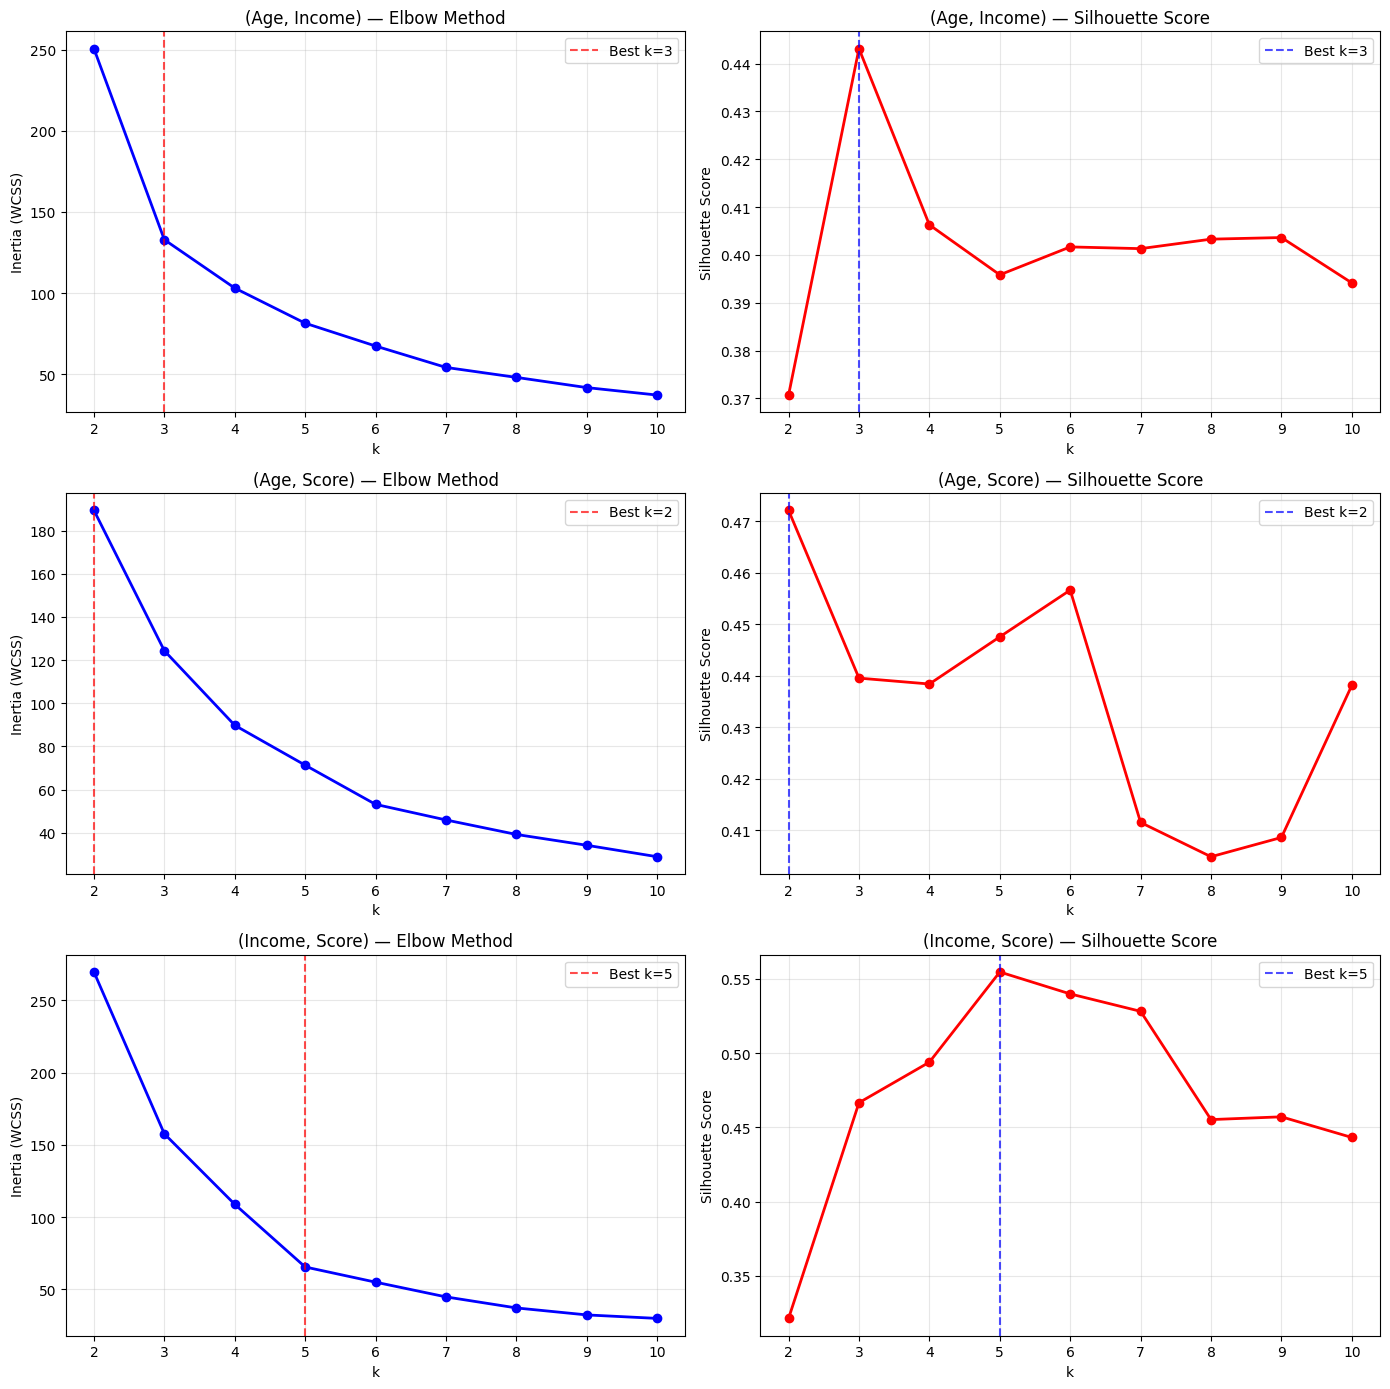

In [28]:
# Plot Elbow and Silhouette for each feature pair
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

for idx, (pair_name, res) in enumerate(pair_results.items()):
    # Elbow Method
    axes[idx, 0].plot(
        list(k_range_pairs), res['inertias'],
        'bo-', linewidth=2, markersize=6
    )
    axes[idx, 0].axvline(
        x=res['best_k'], color='red', linestyle='--',
        alpha=0.7, label=f'Best k={res["best_k"]}'
    )
    axes[idx, 0].set_xlabel('k')
    axes[idx, 0].set_ylabel('Inertia (WCSS)')
    axes[idx, 0].set_title(f'{pair_name} — Elbow Method')
    axes[idx, 0].set_xticks(list(k_range_pairs))
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Silhouette Score
    axes[idx, 1].plot(
        list(k_range_pairs), res['silhouette_scores'],
        'ro-', linewidth=2, markersize=6
    )
    axes[idx, 1].axvline(
        x=res['best_k'], color='blue', linestyle='--',
        alpha=0.7, label=f'Best k={res["best_k"]}'
    )
    axes[idx, 1].set_xlabel('k')
    axes[idx, 1].set_ylabel('Silhouette Score')
    axes[idx, 1].set_title(f'{pair_name} — Silhouette Score')
    axes[idx, 1].set_xticks(list(k_range_pairs))
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 5: Gender-Based Cluster Analysis

Plot the clusters for each feature pair and distinguish data points by Gender. Investigate whether gender reveals customer sub-segments.

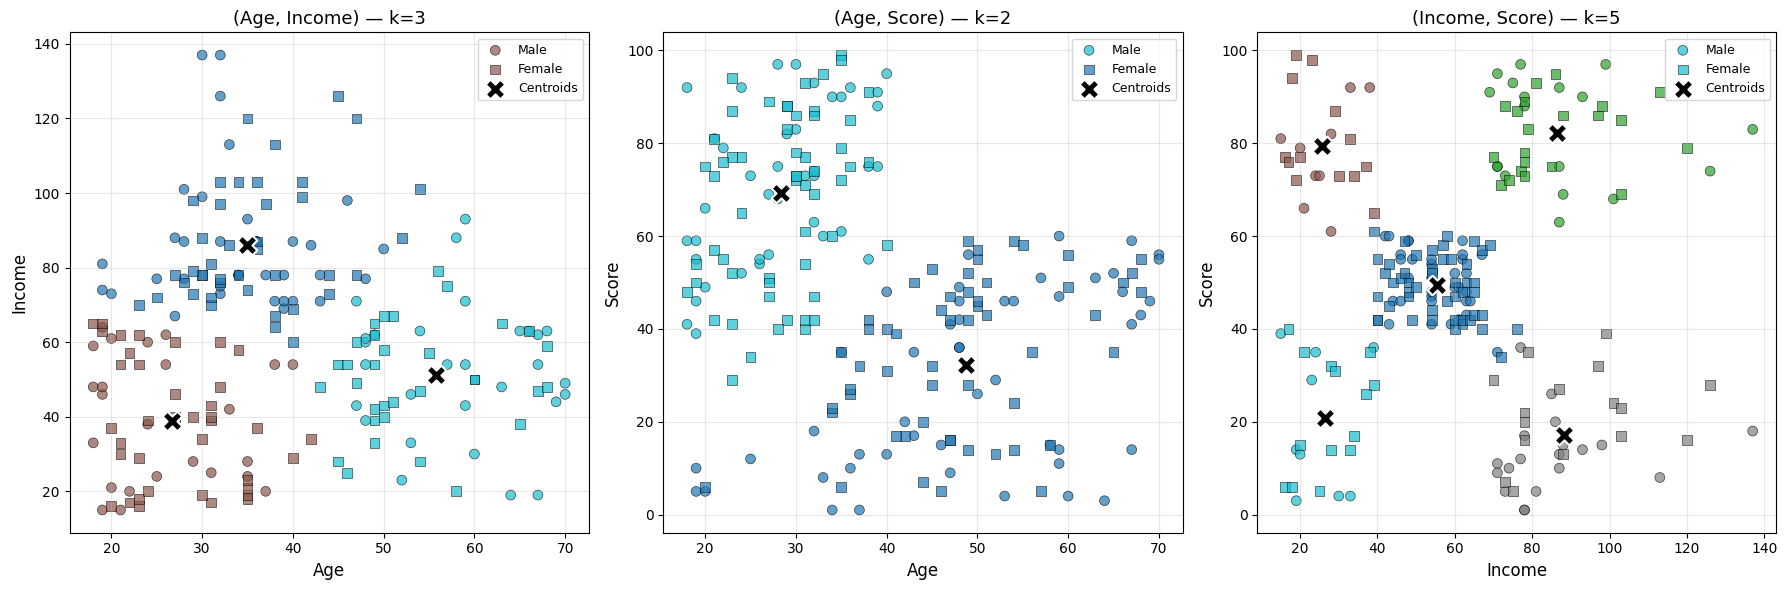

In [29]:
# Cluster each feature pair with its best k and visualise with gender
gender_markers = {'Male': 'o', 'Female': 's'}
gender_colours = {'Male': 'steelblue', 'Female': 'coral'}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (pair_name, res) in enumerate(pair_results.items()):
    feat1, feat2 = res['features']
    best_k_pair = res['best_k']
    X_pair = df_normalised[[feat1, feat2]].values

    # Fit K-means with the best k for this pair
    km_pair = KMeans(n_clusters=best_k_pair, n_init=10, random_state=42)
    pair_labels = km_pair.fit_predict(X_pair)

    # Plot with gender differentiation
    ax = axes[idx]
    for gender in ['Male', 'Female']:
        mask = df['Gender'] == gender
        scatter = ax.scatter(
            df.loc[mask, feat1],
            df.loc[mask, feat2],
            c=pair_labels[mask],
            cmap='tab10',
            marker=gender_markers[gender],
            edgecolors='black',
            linewidths=0.5,
            alpha=0.7,
            s=50,
            label=gender,
            vmin=0,
            vmax=best_k_pair - 1
        )

    # Denormalise centroids for this pair
    pair_scaler_mean = scaler.mean_[
        [numerical_features.index(feat1),
         numerical_features.index(feat2)]
    ]
    pair_scaler_std = scaler.scale_[
        [numerical_features.index(feat1),
         numerical_features.index(feat2)]
    ]
    centroids_pair_orig = (
        km_pair.cluster_centers_ * pair_scaler_std + pair_scaler_mean
    )
    ax.scatter(
        centroids_pair_orig[:, 0],
        centroids_pair_orig[:, 1],
        c='black', marker='X', s=200,
        edgecolors='white', linewidths=1.5,
        zorder=5, label='Centroids'
    )

    ax.set_xlabel(feat1, fontsize=12)
    ax.set_ylabel(feat2, fontsize=12)
    ax.set_title(f'{pair_name} — k={best_k_pair}', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# Gender distribution within each cluster (per feature pair)
for pair_name, res in pair_results.items():
    feat1, feat2 = res['features']
    X_pair = df_normalised[[feat1, feat2]].values
    km_pair = KMeans(
        n_clusters=res['best_k'], n_init=10, random_state=42
    )
    pair_labels = km_pair.fit_predict(X_pair)

    print(f"\n{'='*50}")
    print(f"Feature pair: {pair_name} (k={res['best_k']})")
    print('='*50)
    cross_tab = pd.crosstab(
        pair_labels, df['Gender'],
        margins=True, margins_name='Total'
    )
    cross_tab.index.name = 'Cluster'
    print(cross_tab)


Feature pair: (Age, Income) (k=3)
Gender   Female  Male  Total
Cluster                     
0            41    35     76
1            38    24     62
2            33    29     62
Total       112    88    200

Feature pair: (Age, Score) (k=2)
Gender   Female  Male  Total
Cluster                     
0            55    48    103
1            57    40     97
Total       112    88    200

Feature pair: (Income, Score) (k=5)
Gender   Female  Male  Total
Cluster                     
0            48    33     81
1            21    18     39
2            13     9     22
3            16    19     35
4            14     9     23
Total       112    88    200


### Analysis: Gender and Sub-Segments
In all cases, both genders appear in every cluster. The clusters do not show a clear separation between Male and Female customers. This is also confirmed by the tables, where the number of Male and Female customers in each cluster is relatively balanced. No cluster is mainly composed of a single gender.

When comparing these plots to the earlier clustering results, no new customer subsegments can be identified by looking at Gender. The clusters are still mainly defined by numerical variables such as Income and Spending Score, with Age playing a secondary role. Gender does not change the structure of the clusters.

For this reason, converting Gender into a binary variable and including it in the K-means algorithm is not worthwhile. K-means is based on distance calculations, and adding Gender would not help separate customers in a meaningful way. Instead, it could introduce noise without improving the quality or interpretation of the clusters.

## Section 6: Hierarchical Clustering on the Noisy Dataset

Load `customers_noisy.csv`, which contains the four original features (Gender is now binary) plus four noisy features. Perform hierarchical clustering on all features and plot the dendrogram.

In [31]:
# Load the noisy dataset
df_noisy = pd.read_csv('customers_noisy.csv')
print(f"Dataset shape: {df_noisy.shape}")
print(f"Columns: {list(df_noisy.columns)}")
df_noisy.head()

Dataset shape: (200, 8)
Columns: ['Gender', 'Age', 'Income', 'Score', 'Noisy1', 'Noisy2', 'Noisy3', 'Noisy4']


,Gender,Age,Income,Score,Noisy1,Noisy2,Noisy3,Noisy4
0,0,19,15,39,25,89,33,93
1,0,21,15,81,21,95,51,106
2,1,20,16,6,25,84,38,86
3,1,23,16,77,23,95,28,79
4,1,31,17,40,21,87,38,96


In [32]:
# Z-score normalise all features (Gender is already binary, but we
# normalise all to ensure equal weighting in distance computation)
noisy_features = df_noisy.columns.tolist()
scaler_noisy = StandardScaler()
X_noisy_normalised = scaler_noisy.fit_transform(df_noisy[noisy_features])

print("Normalised noisy dataset (first 5 rows):")
print(pd.DataFrame(
    X_noisy_normalised,
    columns=noisy_features
).head())

Normalised noisy dataset (first 5 rows):
     Gender       Age    Income     Score    Noisy1    Noisy2    Noisy3  \
0 -1.128152 -1.424569 -1.738999 -0.434801 -0.139536  0.137969 -1.263043   
1 -1.128152 -1.281035 -1.738999  1.195704 -0.978851  0.762734  1.342662   
2  0.886405 -1.352802 -1.700830 -1.715913 -0.139536 -0.382668 -0.539236   
3  0.886405 -1.137502 -1.700830  1.040418 -0.559193  0.762734 -1.986850   
4  0.886405 -0.563369 -1.662660 -0.395980 -0.978851 -0.070286 -0.539236   

     Noisy4  
0  0.639124  
1  2.075358  
2 -0.134233  
3 -0.907589  
4  0.970563  


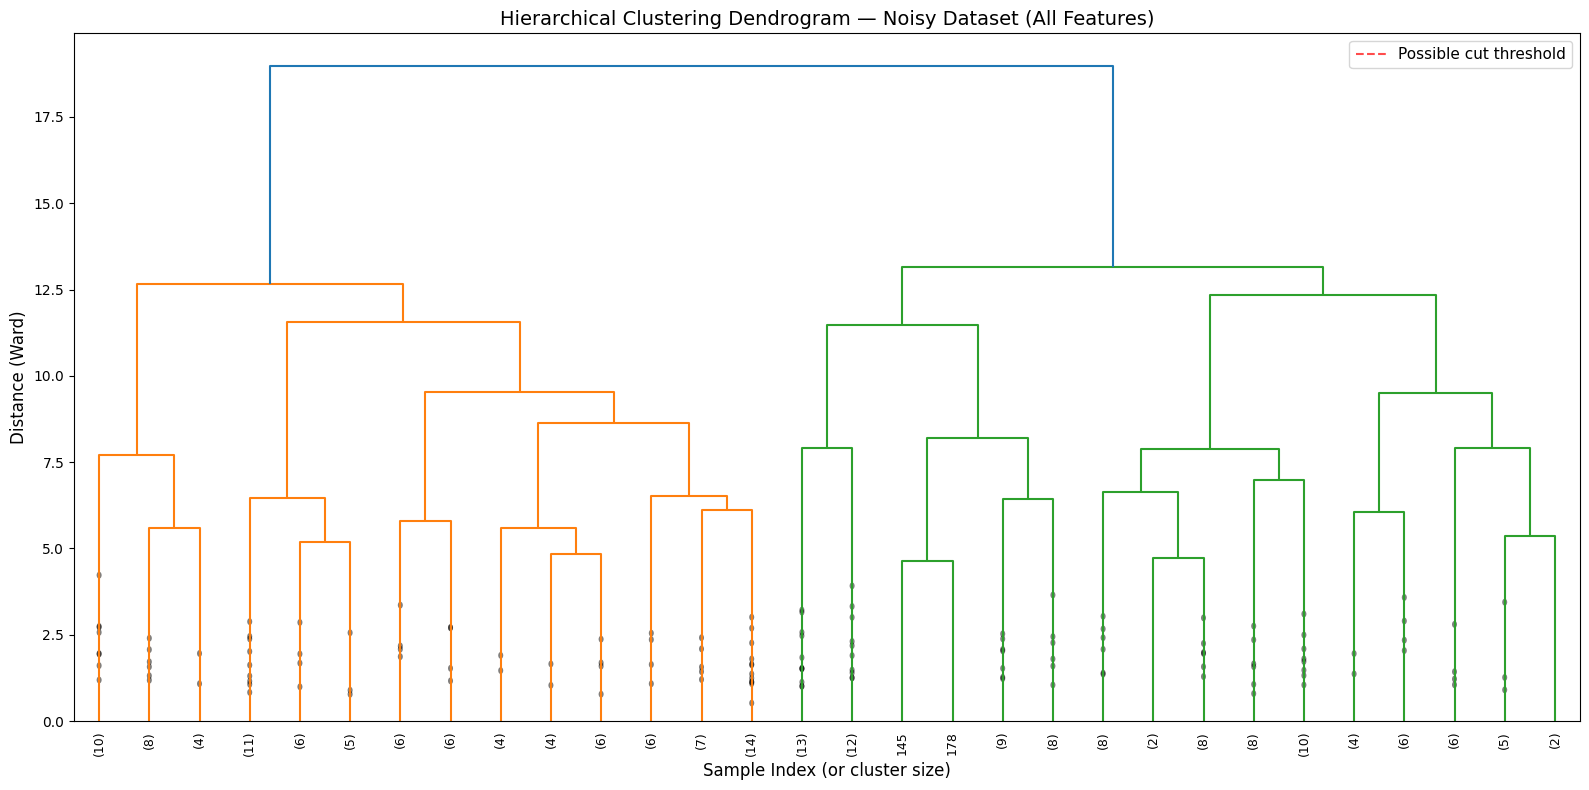

In [33]:
# Perform hierarchical (agglomerative) clustering using Ward's method
Z = linkage(X_noisy_normalised, method='ward', metric='euclidean')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90,
    leaf_font_size=9,
    show_contracted=True,
    ax=ax
)
ax.set_xlabel('Sample Index (or cluster size)', fontsize=12)
ax.set_ylabel('Distance (Ward)', fontsize=12)
ax.set_title(
    'Hierarchical Clustering Dendrogram — Noisy Dataset (All Features)',
    fontsize=14
)
ax.axhline(y=50, color='r', linestyle='--', alpha=0.7,
           label='Possible cut threshold')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

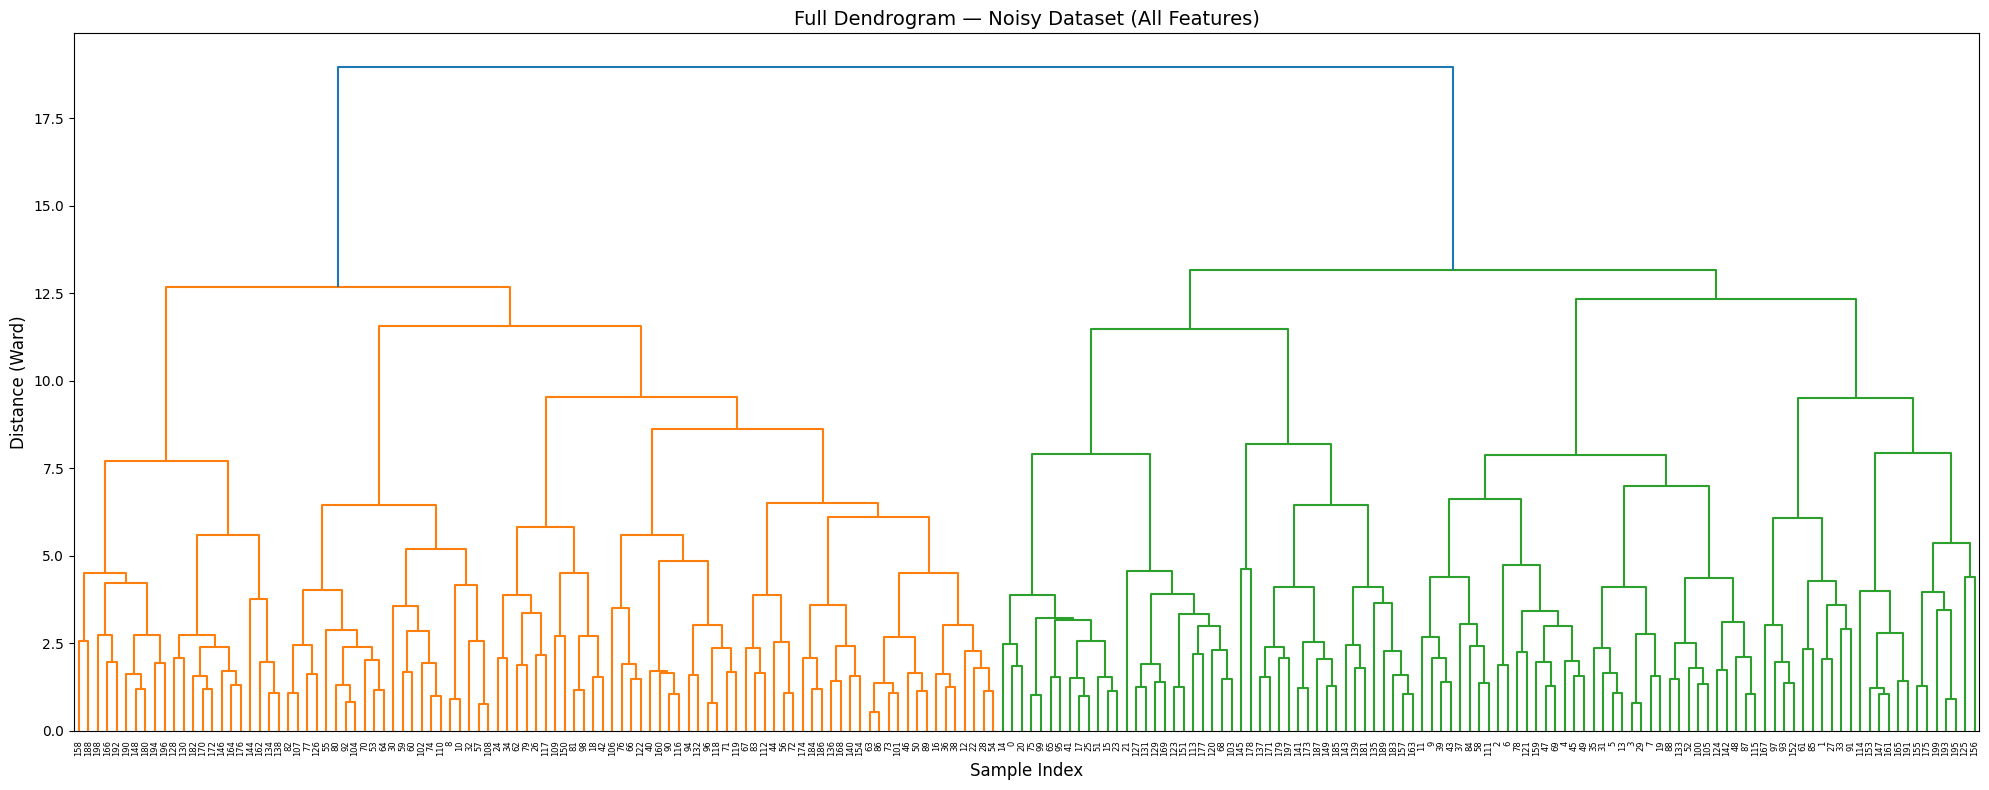

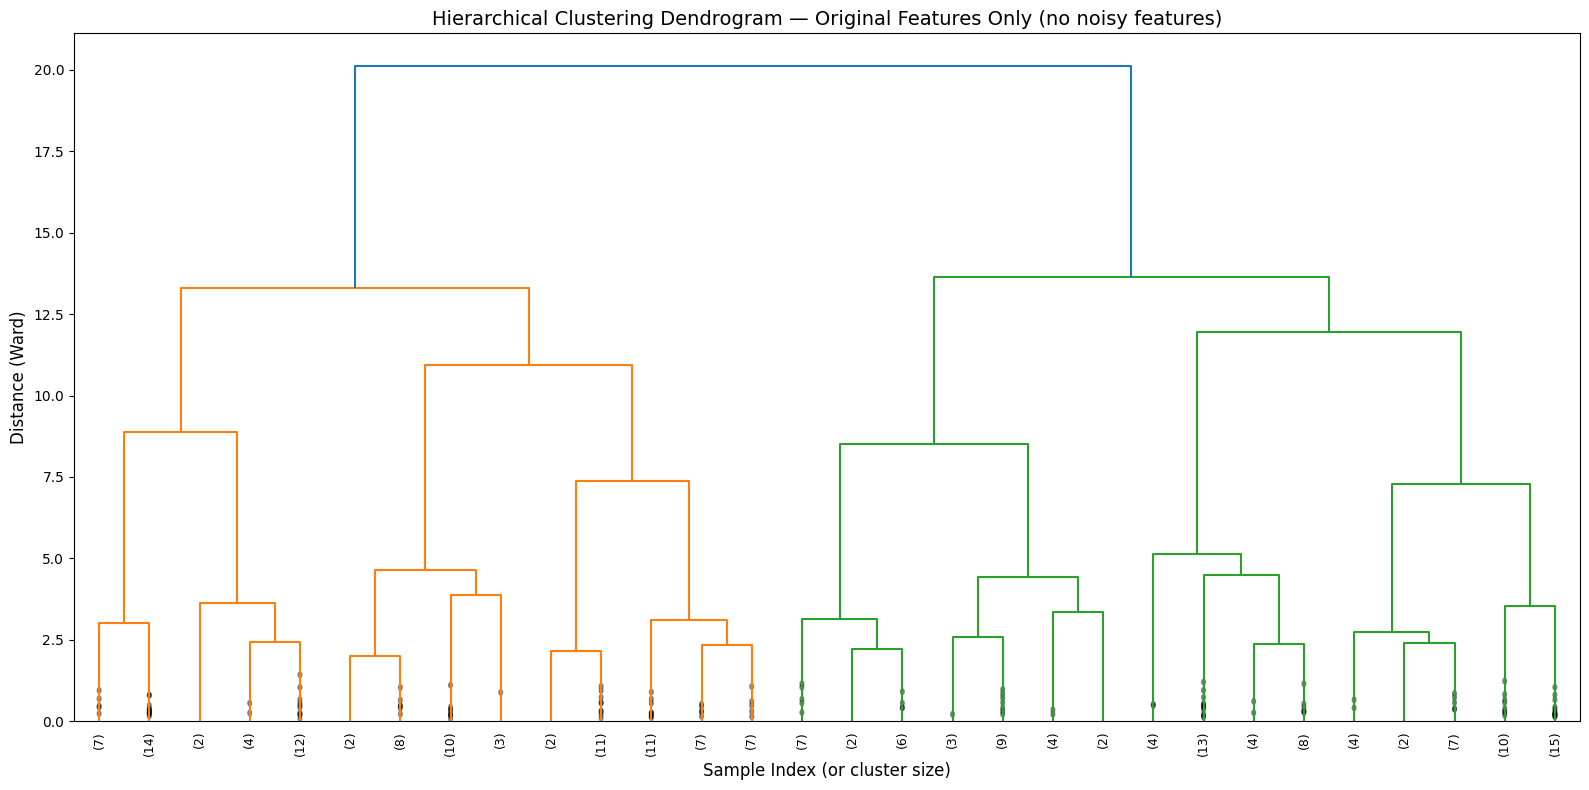

In [34]:
# Full dendrogram (no truncation) for detailed view
fig, ax = plt.subplots(figsize=(20, 8))
dendrogram(
    Z,
    leaf_rotation=90,
    leaf_font_size=6,
    ax=ax
)
ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('Distance (Ward)', fontsize=12)
ax.set_title(
    'Full Dendrogram — Noisy Dataset (All Features)',
    fontsize=14
)
plt.tight_layout()
plt.show()

# Compare: hierarchical clustering on original features only
original_cols = ['Gender', 'Age', 'Income', 'Score']
X_orig_only = scaler_noisy.fit_transform(df_noisy[original_cols])
Z_orig = linkage(X_orig_only, method='ward', metric='euclidean')

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    Z_orig,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90,
    leaf_font_size=9,
    show_contracted=True,
    ax=ax
)
ax.set_xlabel('Sample Index (or cluster size)', fontsize=12)
ax.set_ylabel('Distance (Ward)', fontsize=12)
ax.set_title(
    'Hierarchical Clustering Dendrogram — Original Features Only '
    '(no noisy features)',
    fontsize=14
)
plt.tight_layout()
plt.show()

### Interpretation of Hierarchical Clustering on Noisy Data

The dendrogram built using all features including the noisy ones is difficult to interpret. The branches merge gradually and there is no clear height at which a small number of well separated clusters can be identified. Many points are combined at similar distances, which suggests that the structure of the data is blurred. The noisy features add randomness and reduce the contrast between groups.

When looking at the full dendrogram for the noisy dataset, the tree appears deep and crowded. Clusters keep merging step by step without large jumps in distance. This means that customers are not clearly grouped and that the added noisy variables strongly affect the distance calculations used by hierarchical clustering.

In contrast, the dendrogram based only on the original features shows a much clearer structure. Large vertical gaps appear before the final merges, indicating well separated clusters. The grouping is more stable and easier to interpret, and the cluster structure is consistent with what was observed earlier in the analysis.

In short, the comparison shows that noisy features strongly degrade the quality of hierarchical clustering. When irrelevant variables are included, meaningful customer groups become harder to detect. Using only the original features leads to clearer clusters and more reliable conclusions.